In [2]:
import tensorflow as tf
import os
model = tf.keras.models.load_model('./three_image(3_label)_MobileNet')

In [3]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline 

def get_image(filename):
    satpath = f'data/for_visualization/folium_images/{filename}.png'
    dempath = f'data/for_visualization/dem_images/{filename}_dem.png'
    roadpath = f'data/for_visualization/osmnx_images/{filename}.png'

    if os.path.exists(dempath) and os.path.exists(satpath) and os.path.exists(roadpath):
        sat_image = np.array([tf.keras.utils.img_to_array(Image.open(satpath).convert('RGB').resize((128, 128)))])
        dem_image = np.array([tf.keras.utils.img_to_array(Image.open(dempath).convert('RGB').resize((128, 128)))])
        osm_image = np.array([tf.keras.utils.img_to_array(Image.open(roadpath).convert('RGB').resize((128, 128)))])
        
        sat_image = tf.keras.applications.mobilenet_v2.preprocess_input(sat_image)
        dem_image = tf.keras.applications.mobilenet_v2.preprocess_input(dem_image)
        osm_image = tf.keras.applications.mobilenet_v2.preprocess_input(osm_image)
        
        fig = plt.figure()
        rows = 1
        cols = 3
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(cv2.imread(satpath), interpolation='nearest')

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(cv2.imread(dempath), interpolation='nearest')

        ax3 = fig.add_subplot(rows, cols, 3)
        ax3.imshow(cv2.imread(roadpath), interpolation='nearest')
        plt.show()
        
        return [sat_image, dem_image, osm_image]
    
    return [None, None, None, None]

def pred_img(lat, lon, idx):
    imgs = get_image(f'{lat[idx]}_{lon[idx]}')
    print('idx: ', idx)
    if len(imgs) != 3:
        print(0)
    else:
        pred = model.predict(imgs)
        print(pred)
        print('level: ', np.argmax(pred, axis=1)[0])

In [4]:
import geopandas as gpd

df = gpd.read_file('./data/final_GW_road_grid.geojson', driver='GeoJSON')


## 위험도 0 도로들

In [5]:
lat_0 = df[df['class'] == 0]['lat'].values.tolist()
lon_0 = df[df['class'] == 0]['lon'].values.tolist()
idx_0 = 0

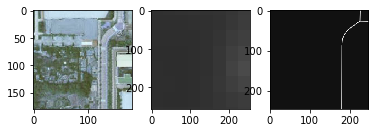

idx:  0
1/1 [==============================] - 5s 5s/step
[[9.9999702e-01 2.9501259e-06 3.9194042e-10]]
level:  0


In [6]:
pred_img(lat_0, lon_0, idx_0)
idx_0 += 1

## 위험도 1 도로들

In [147]:
lat_1 = df[df['class'] == 1]['lat'].values.tolist()
lon_1 = df[df['class'] == 1]['lon'].values.tolist()
idx_1 = 0

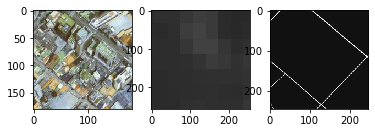

idx:  21
1/1 [==============================] - 0s 46ms/step
[[3.0476816e-02 9.6899009e-01 5.3305330e-04]]
level:  1


In [235]:
pred_img(lat_1, lon_1, idx_1)
idx_1 += 1

## 위험도 2 도로들

In [236]:
lat_2 = df[df['class'] == 2]['lat'].values.tolist()
lon_2 = df[df['class'] == 2]['lon'].values.tolist()
idx_2 = 0

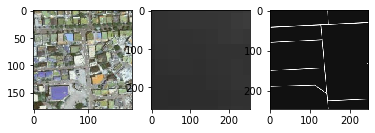

idx:  0
1/1 [==============================] - 0s 34ms/step
[[0.08043884 0.36405757 0.5555036 ]]
level:  2


In [237]:
pred_img(lat_2, lon_2, idx_2)
idx_2 += 1

## 광주광역시 이륜차 위험 다발지 예측

In [238]:
import folium
import pandas as pdc

# 광주광역시 중심 좌표입니다.
center = [35.1595454, 126.8526012]

# 맵이 center 에 위치하고, zoom 레벨은 11로 시작하는 맵 m을 만듭니다.
m = folium.Map(location=center, zoom_start=12)

# Choropleth 레이어를 만들고, 맵 m에 추가합니다.
folium.Choropleth(
    geo_data='./data/final_GW_road_grid.geojson',
    data = df,
    columns=['id' , 'class'],
    key_on = 'feature.properties.id',
    fill_color='Reds', 

    
).add_to(m)
accident = pdc.read_csv('./data/17_21_이륜차_사고다발지역(좌표o).csv', encoding = 'cp949', engine='python', index_col=0, header=0)

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(m)
for lat, lon in zip(accident['위도'], accident['경도']):
    folium.CircleMarker([lat, lon],
                    # color='tomato',
                    radius = 10).add_to(m)
# 맵 m을 출력합니다.
m